In [16]:
import torch
from torch import nn
import numpy as np
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt

warnings.filterwarnings("ignore")

In [2]:
with open(r"../../data/anek_djvu.txt", "r", encoding="utf-8") as f:
    text = f.read()
    f.close()
text[118:500]

'|startoftext|>Это ГООООЛ\n\n<|startoftext|>Это ГООООЙЙЙДАААА!\n\n<|startoftext|>Друзья мои, чтобы соответствовать вам, я готов сделать над собой усилие и стать лучше. Но тогда и вы станьте немного хуже!\n\n<|startoftext|>- Люся, ты все еще хранишь мой подарок?- Да.- Я думал, ты выкинула все, что со мной связано.- Плюшевый мишка не виноват, что ты ебл@н...\n\n<|startoftext|>- А вот скажи '

In [5]:
def cut_data(text):
    return text.replace("\n\n", "").split("<|startoftext|>")[1:]

cut_text = cut_data(text)
cut_text[14:20]

['- Чему вы так радуетесь, можете поделиться?- Самому не хватает.',
 '- Почему такая красивая и без долбо@ба?',
 'Новая награда Росгвардии - медаль "За взятие студента".',
 'Люди, которые знают, как заработать миллионы на Форексе, но вместо этого обучающие этому за 300$ - вот мои настоящие герои.',
 '- Почему ты рассталась с Петей?- Он не давал мне того, чего я ожидала.- А чего ты ожидала?- Я не знаю. Он мне этого не давал...',
 'Только наш главбух может назначить срочное совещание и не придти на него.']

In [19]:
from staff import Tokenizer, JokesDataset, training_step

tokenizer = Tokenizer(text, 64)
dataset = JokesDataset(tokenizer, cut_text, 64)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

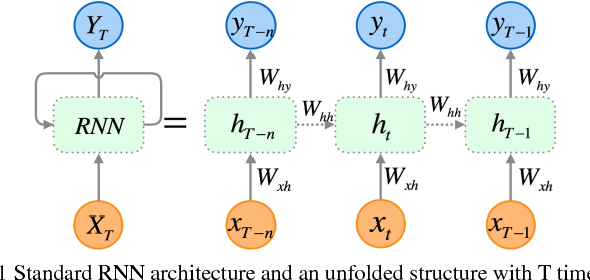

In [ ]:
class RNNLayer(nn.Module):
    def __init__(self, input_size: int, hidden_size: int):
        super().__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.activation = torch.tanh

        self.Wx = nn.Parameter(torch.randn(hidden_size, input_size))
        self.Wh = nn.Parameter(torch.randn(hidden_size, hidden_size))
        self.bias = nn.Parameter(torch.zeros(hidden_size))
    
    def forward(self, x: torch.Tensor, hidden = None):
        batch_size, seq_len, _ = x.shape
        if hidden is None:
            hidden = torch.zeros(batch_size, self.hidden_size)
        outputs = []
        for t in range(seq_len):
            x_t = x[:, t, :]
            h_t = self.activation(torch.matmul(x_t, self.Wx.t()) + torch.matmul(hidden, self.Wh.t()) + self.bias)
            outputs.append(h_t)
            hidden = h_t
        return torch.stack(outputs, dim=1), hidden

In [ ]:
class CharRNN2(nn.Module):
    def __init__(
        self,
        tokenizer,
        hidden_dim: int = 256,
        num_layers: int = 2,
        drop_prob: float = 0.5,
        max_len: int = 32,
    ) -> None:
        super().__init__()
        self.n_hidden = hidden_dim
        self.n_layers = num_layers
        self.drop_prob = drop_prob
        self.max_len = max_len
        self.tokenizer = tokenizer
        self.vocab_size = tokenizer.vocab_size
        self.rnn = RNNLayer(self.vocab_size, hidden_dim)
        self.dropout = nn.Dropout(drop_prob)
        self.fc = nn.Linear(hidden_dim, self.vocab_size)

    def forward(
        self, x: torch.Tensor, lengths: torch.Tensor):
        lengths, sort_idx = lengths.sort(0, descending=True)
        x = x[sort_idx]
        one_hot = torch.nn.functional.one_hot(x, num_classes=self.vocab_size).float()
        outputs, hidden = self.rnn(one_hot)
        out = self.dropout(outputs)
        out = self.fc(out)
        _, unsort_idx = sort_idx.sort(0)
        out = out[unsort_idx]
        lengths = lengths[unsort_idx]

        return out, hidden

    def inference(self, prefix='<bos>'):
        tokens = torch.tensor([self.tokenizer.encode_symbol(prefix)]).unsqueeze(0)
        h = None
        while tokens.shape[1] < self.max_len:
            last_token = tokens[:, -1]
            one_hot = torch.nn.functional.one_hot(last_token, num_classes=self.vocab_size).float()
            one_hot = one_hot.unsqueeze(1)  
            out, h = self.rnn(one_hot, h)
            logits = self.fc(out.squeeze(1))
            probs = torch.softmax(logits, dim=-1)
            new_token = torch.multinomial(probs, num_samples=1)
            tokens = torch.cat([tokens, new_token], dim=1)
            if new_token.item() == self.tokenizer.encode_symbol('<eos>'):
                break
        return self.tokenizer.decode(tokens.squeeze().tolist())

In [29]:
batch_size = 4
seq_length = 128
n_hidden = 32
n_layers = 3
drop_prob = 0.1
lr = 0.1

In [30]:
model = CharRNN2(tokenizer, n_hidden, n_layers, drop_prob, max_len=256)
hidden = None
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-2)

In [31]:
print(model.inference())

<bos>#@手К5▒яцПрhO»HEБHцB,ФW会s<bos>Ij应QXC​Eд&т1“☻ЪG名X命YоAЩyФ表°Мф7аШXёСФТs;ыЩ"
Б6сP会_М;+B|h副5пYёο*已С<eos>


In [32]:
def plot_losses(losses):
    clear_output()
    plt.plot(range(1, len(losses) + 1), losses)
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.show()

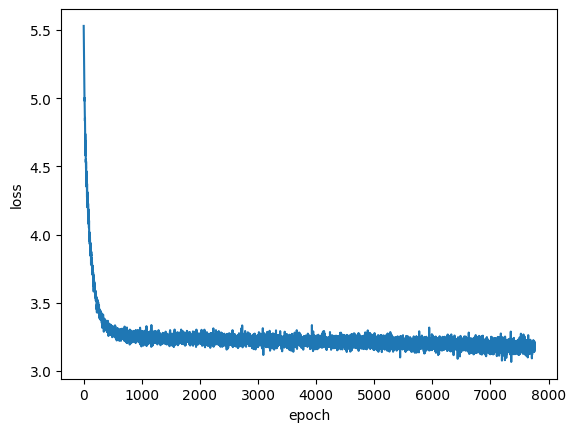

In [33]:
losses = []
num_epochs = 4

for epoch in range(1, num_epochs + 1):
    # your code: run model traininig for n epochs
    for item in dataloader:
        loss = training_step(model, item, tokenizer.vocab_size, criterion, optimizer)
        losses.append(loss)
    plot_losses(losses)
    torch.save(model.state_dict(), f"rnn_c.pt")

In [41]:
print(model.inference())

<bos>-.Яас "артещ ао  откдн л.счткривноь ьальи-х<pad> <eos>
